In [1]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
#from main.feature import get_all_features
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from pickle import load
from sklearn.metrics import mean_squared_error

In [2]:
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)


In [3]:
def make_generator_model(input_dim, output_dim, feature_size) -> tf.keras.models.Model:

    model = Sequential()
    model.add(GRU(units=1024, return_sequences = True, input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.2))
    model.add(GRU(units=512, return_sequences = True, recurrent_dropout=0.2)) # 256, return_sequences = True
    model.add(GRU(units=256, recurrent_dropout=0.2)) #, recurrent_dropout=0.1
    # , recurrent_dropout = 0.2
    model.add(Dense(128))
    # model.add(Dense(128))
    model.add(Dense(64))
    #model.add(Dense(16))
    model.add(Dense(units=output_dim))
    return model

In [4]:
def make_discriminator_model():

    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=5, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Flatten())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [5]:
model = make_discriminator_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 32)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             10304     
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 128)            41088     
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 220)               28160     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 220)               0         
                                                                 
 dense_1 (Dense)             (None, 220)               4

c:\Users\simon\Desktop\price_predict_god\my-python-app\Pforproject\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
c:\Users\simon\Desktop\price_predict_god\my-python-app\Pforproject\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


epoch 15 d_loss 1.368557 g_loss 0.71265924
epoch 30 d_loss 1.3868101 g_loss 0.70502716
epoch 45 d_loss 1.3819958 g_loss 0.7039697
epoch 60 d_loss 1.384789 g_loss 0.6936515
epoch 75 d_loss 1.3860972 g_loss 0.6914959
epoch 90 d_loss 1.3861971 g_loss 0.69199413
epoch 105 d_loss 1.3863416 g_loss 0.69271874
epoch 120 d_loss 1.3863451 g_loss 0.69316447
epoch 135 d_loss 1.3863018 g_loss 0.69328856
epoch 150 d_loss 1.3862989 g_loss 0.6932152
epoch 165 d_loss 1.386364 g_loss 0.6929642


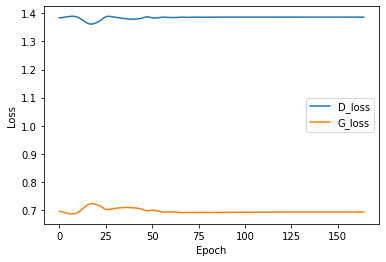

In [6]:
class GAN:
    def __init__(self, generator, discriminator, opt):
        self.opt = opt
        self.lr = opt["lr"]
        self.generator = generator
        self.discriminator = discriminator
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.generator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.discriminator_optimizer = tf.keras.optimizers.Adam(lr=self.lr)
        self.batch_size = self.opt['bs']
        self.checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                              discriminator_optimizer=self.discriminator_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def discriminator_loss(self, real_output, fake_output):
        real_loss = self.cross_entropy(tf.ones_like(real_output), real_output)
        fake_loss = self.cross_entropy(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake_output):
        return self.cross_entropy(tf.ones_like(fake_output), fake_output)

    @tf.function
    def train_step(self, real_x, real_y, yc):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_data = self.generator(real_x, training=True)
            generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
            d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
            real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
            d_real_input = tf.concat([real_y_reshape, yc], axis=1)

            # Reshape for MLP
            # d_fake_input = tf.reshape(d_fake_input, [d_fake_input.shape[0], d_fake_input.shape[1]])
            # d_real_input = tf.reshape(d_real_input, [d_real_input.shape[0], d_real_input.shape[1]])

            real_output = self.discriminator(d_real_input, training=True)
            fake_output = self.discriminator(d_fake_input, training=True)

            gen_loss = self.generator_loss(fake_output)
            disc_loss = self.discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables))
        return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': gen_loss}

    def train(self, real_x, real_y, yc, opt):
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []

        epochs = opt["epoch"]
        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(real_x, real_y, yc)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price.numpy())
            Real_price.append(real_price.numpy())

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_model_3_1_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix + f'-{epoch}')
                print('epoch', epoch + 1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())
            # print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))
            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(
            Real_price)


if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]

    ## For Bayesian
    opt = {"lr": 0.00016, "epoch": 165, 'bs': 128}

    generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = make_discriminator_model()
    gan = GAN(generator, discriminator, opt)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, opt)

In [8]:
# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("train_predict_index.npy", allow_pickle=True)
test_predict_index = np.load("test_predict_index.npy", allow_pickle=True)
#dataset_train = pd.read_csv('dataset_train.csv', index_col=0)

In [9]:
print("----- predicted price -----", Predicted_price)

----- predicted price ----- [[-0.82042193]
 [-0.8244421 ]
 [-0.82141244]
 [-0.8212348 ]
 [-0.82553405]
 [-0.830838  ]
 [-0.8298956 ]
 [-0.8355498 ]
 [-0.8206837 ]
 [-0.8108376 ]
 [-0.8043893 ]
 [-0.79881024]
 [-0.78960204]
 [-0.79341006]
 [-0.78837097]
 [-0.7848191 ]
 [-0.78174126]
 [-0.7733974 ]
 [-0.7777995 ]
 [-0.7602231 ]
 [-0.7650347 ]
 [-0.75508535]
 [-0.7456435 ]
 [-0.746539  ]
 [-0.7391286 ]
 [-0.73478496]
 [-0.73839134]
 [-0.73818755]
 [-0.7520609 ]
 [-0.7765854 ]
 [-0.80973446]
 [-0.8225137 ]
 [-0.8361273 ]
 [-0.8441395 ]
 [-0.8560276 ]
 [-0.8471167 ]
 [-0.83631015]
 [-0.826735  ]
 [-0.82154614]
 [-0.8155326 ]
 [-0.8051044 ]
 [-0.79551446]
 [-0.79985756]
 [-0.7906868 ]
 [-0.7826023 ]
 [-0.7813233 ]
 [-0.7984483 ]
 [-0.810089  ]
 [-0.8241602 ]
 [-0.8174058 ]
 [-0.8088057 ]
 [-0.7939353 ]
 [-0.80054784]
 [-0.7848312 ]
 [-0.7732501 ]
 [-0.7722334 ]
 [-0.7648487 ]
 [-0.76990086]
 [-0.77512616]
 [-0.78996474]
 [-0.7978537 ]
 [-0.80909455]
 [-0.8285688 ]
 [-0.83646107]
 [-0.8580843

In [10]:
rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

In [11]:
print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)


----- rescaled predicted price ----- [[1159.2064]
 [1155.11  ]
 [1158.197 ]
 [1158.378 ]
 [1153.9973]
 [1148.5927]
 [1149.5529]
 [1143.7915]
 [1158.9397]
 [1168.9727]
 [1175.5433]
 [1181.2283]
 [1190.6112]
 [1186.731 ]
 [1191.8657]
 [1195.485 ]
 [1198.6212]
 [1207.1235]
 [1202.6378]
 [1220.5479]
 [1215.6449]
 [1225.7831]
 [1235.4042]
 [1234.4916]
 [1242.0427]
 [1246.4688]
 [1242.794 ]
 [1243.0016]
 [1228.8649]
 [1203.875 ]
 [1170.0967]
 [1157.075 ]
 [1143.203 ]
 [1135.0387]
 [1122.9249]
 [1132.005 ]
 [1143.0166]
 [1152.7734]
 [1158.0609]
 [1164.1886]
 [1174.8147]
 [1184.5865]
 [1180.1611]
 [1189.506 ]
 [1197.7438]
 [1199.0471]
 [1181.597 ]
 [1169.7355]
 [1155.3971]
 [1162.2798]
 [1171.0431]
 [1186.1958]
 [1179.4576]
 [1195.4727]
 [1207.2736]
 [1208.3096]
 [1215.8344]
 [1210.6864]
 [1205.3619]
 [1190.2417]
 [1182.203 ]
 [1170.7488]
 [1150.9049]
 [1142.8628]
 [1120.8292]
 [1111.7174]
 [1102.2994]
 [1107.9468]
 [1107.7264]
 [1093.6797]
 [1108.3663]
 [1120.2117]
 [1107.407 ]
 [1107.8229]
 

In [12]:
predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

In [13]:
real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

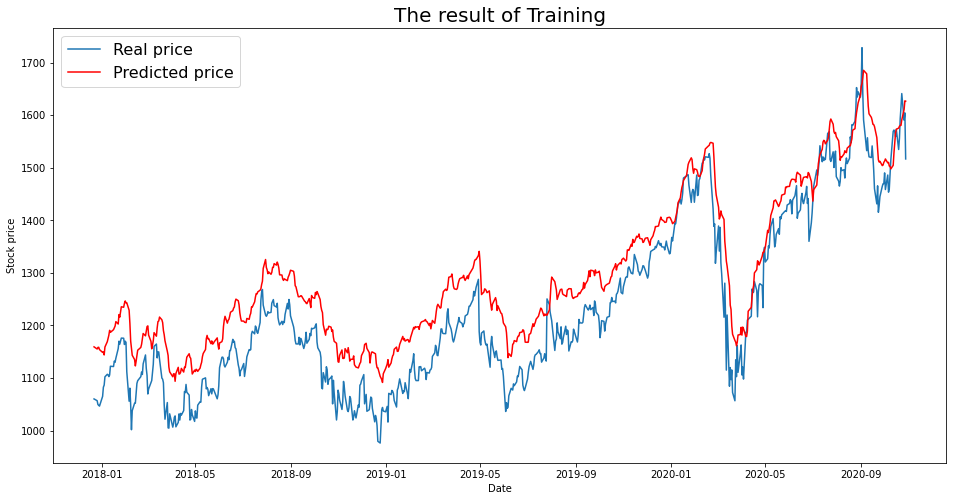

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()

In [15]:
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

-- Train RMSE --  76.08060486798603
